In [1]:
import autoencoder_conv2d

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from clusteringlayer import ClusteringLayer
from tensorflow.keras.initializers import VarianceScaling
from sklearn.utils.linear_assignment_ import linear_assignment

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

In [4]:
autoencoder, encoder = autoencoder_conv2d.autoencoderConv2D_1()

In [5]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense (Dense)                (None, 1152)              12672    

In [6]:
pretrain_epochs = 20
batch_size = 256

In [7]:
autoencoder.compile(optimizer = 'adadelta', loss = 'mse')

In [8]:
autoencoder.fit(x, x, batch_size = batch_size, epochs = pretrain_epochs, verbose = 2)

Epoch 1/20
274/274 - 8s - loss: 0.1122
Epoch 2/20
274/274 - 2s - loss: 0.1120
Epoch 3/20
274/274 - 2s - loss: 0.1118
Epoch 4/20
274/274 - 2s - loss: 0.1115
Epoch 5/20
274/274 - 2s - loss: 0.1113
Epoch 6/20
274/274 - 2s - loss: 0.1110
Epoch 7/20
274/274 - 2s - loss: 0.1107
Epoch 8/20
274/274 - 2s - loss: 0.1103
Epoch 9/20
274/274 - 2s - loss: 0.1100
Epoch 10/20
274/274 - 2s - loss: 0.1096
Epoch 11/20
274/274 - 2s - loss: 0.1093
Epoch 12/20
274/274 - 2s - loss: 0.1089
Epoch 13/20
274/274 - 2s - loss: 0.1085
Epoch 14/20
274/274 - 2s - loss: 0.1080
Epoch 15/20
274/274 - 2s - loss: 0.1076
Epoch 16/20
274/274 - 2s - loss: 0.1072
Epoch 17/20
274/274 - 2s - loss: 0.1067
Epoch 18/20
274/274 - 2s - loss: 0.1062
Epoch 19/20
274/274 - 3s - loss: 0.1057
Epoch 20/20
274/274 - 3s - loss: 0.1052


In [9]:
# Add clustering layer

clustering_layer = ClusteringLayer(10, name = 'clustering')(encoder.output)
model = tf.keras.models.Model(inputs = encoder.input, outputs = clustering_layer)
model.compile(optimizer = 'adam', loss = 'kld')

In [10]:
# initialize cluster centers using k-means

kmeans = KMeans(n_clusters = 10, n_init = 20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [11]:
y_pred_last = np.copy(y_pred)

In [12]:
model.get_layer(name = 'clustering').set_weights([kmeans.cluster_centers_])

In [13]:
# Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [14]:
loss = 0
index = 0
tol = 0.001
maxiter = 6000
update_interval = 140
index_array = np.arange(x.shape[0])

In [15]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose = 0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x = x[idx], y = p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iter 0: acc = 0.09041, nmi = 0.22625, ari = 0.14565  ; loss= 0
Iter 140: acc = 0.10210, nmi = 0.22079, ari = 0.15251  ; loss= 0.0
Iter 280: acc = 0.10729, nmi = 0.22395, ari = 0.15452  ; loss= 0.0
Iter 420: acc = 0.11540, nmi = 0.22360, ari = 0.15556  ; loss= 0.0
Iter 560: acc = 0.11824, nmi = 0.21927, ari = 0.15217  ; loss= 0.0
Iter 700: acc = 0.11936, nmi = 0.21654, ari = 0.15150  ; loss= 1e-05
Iter 840: acc = 0.11607, nmi = 0.21404, ari = 0.15021  ; loss= 2e-05
Iter 980: acc = 0.11243, nmi = 0.21165, ari = 0.14804  ; loss= 0.00013
Iter 1120: acc = 0.10939, nmi = 0.21396, ari = 0.14824  ; loss= 0.0024
Iter 1260: acc = 0.11291, nmi = 0.22853, ari = 0.15880  ; loss= 0.01724
Iter 1400: acc = 0.12041, nmi = 0.25463, ari = 0.17783  ; loss= 0.07495
Iter 1540: acc = 0.11950, nmi = 0.27923, ari = 0.19862  ; loss= 0.15616
Iter 1680: acc = 0.11923, nmi = 0.30303, ari = 0.21987  ; loss= 0.19535
Iter 1820: acc = 0.11584, nmi = 0.32115, ari = 0.23239  ; loss= 0.21453
Iter 1960: acc = 0.11374, nmi

In [16]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.10876, nmi = 0.40753, ari = 0.29627  ; loss= 0.13634


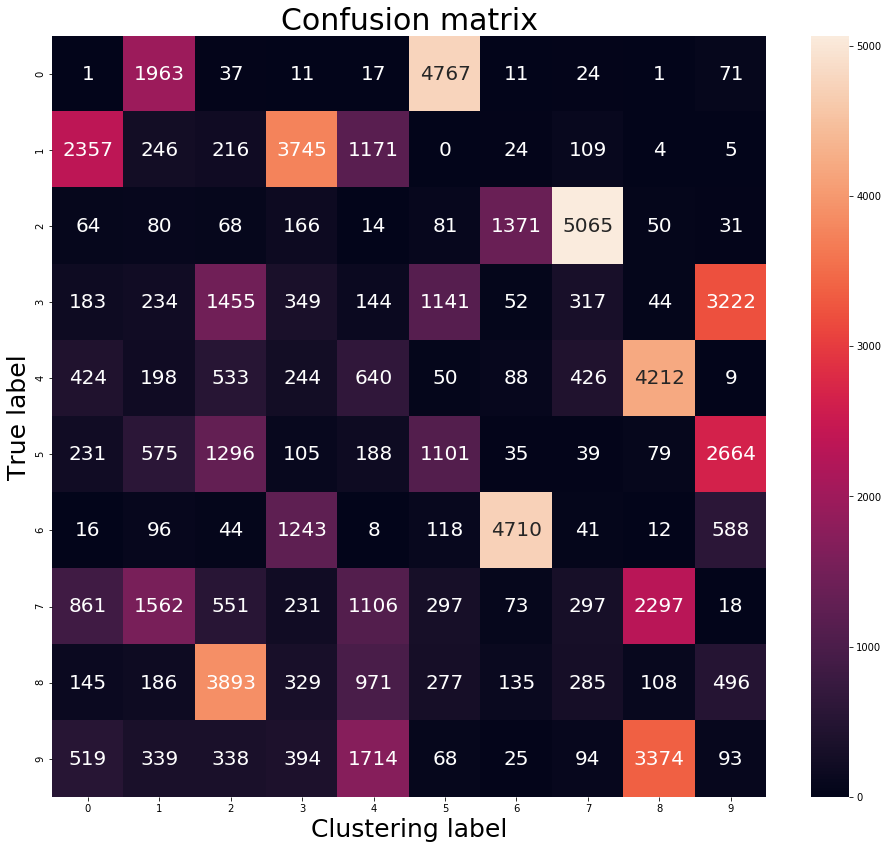

In [18]:
confusion_matrix = metrics.confusion_matrix(y, y_pred)

plt.figure(figsize = (16, 14))
sns.heatmap(confusion_matrix, annot = True, fmt = "d", annot_kws = {"size": 20});
plt.title("Confusion matrix", fontsize = 30)
plt.ylabel('True label', fontsize = 25)
plt.xlabel('Clustering label', fontsize = 25)
plt.show()